# Prevendo Vendas no Varejo: Analise e Previsão de Séries Temporais
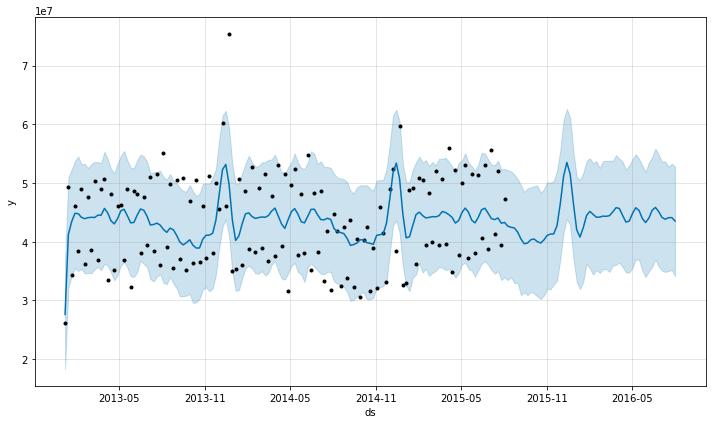

Uma das tarefas mais importantes em qualquer empresa de varejo é analisar a performance de suas lojas. O principal desafio enfrentado por qualquer varejista é prever com antecedência as vendas e o estoque necessário em cada loja para evitar o excesso e a falta de produtos. Isto ajuda o negócio evitando perdas e garantindo que a loja esteja apta para a operação, provendo uma melhor experiencia ao consumidor.

Nesta análise, foram usados dados do grupo ROSSMANN, a segunda maior rede de farmácias da República Federal e um dos 10 varejistas mais importantes da Alemanha em termos de vendas, em 2019 o Grupo ROSSMANN faturou mais de 10 bilhões de euros com os seus mais de 4.000 pontos de venda distribuidos entre Alemanha, Polônia, Hungria, República Tcheca, Albânia, Kosovo e Turquia, atualmente o grupo ocupa a 111ª posição dentre os maiores varejistas do mundo.

O desafio desta análise é prever suas vendas diárias com até 6 semanas de antecedência, considerando que as vendas das lojas são influenciadas por vários fatores, incluindo promoções, concorrência, feriados escolares e estaduais, sazonalidade e localização. Os dados serão submetidos a 3 modelos preditivos que utilizam machine learning (SARIMA, Facebook Prophet e XGBoost) e apresentam bom desempenho em previsão de séries temporais, que possuem impacto da sazonalidade multiplicativa.

A análise esta dividida em duas partes: EDA & Forecasting.

# 1ª. Parte: Análise Exploratória de Dados (EDA)

Iniciaremos importando as bibliotecas necessárias, em seguida os datasets e na sequência realizar a análise exploratória dos dados.


In [1]:
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

### A tabela abaixo fornece informações sobre 1115 lojas pertencentes ao grupo Rossmann.

In [2]:
store = pd.read_csv('store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Importando os dados de treino

In [3]:
train = pd.read_csv('train.csv', index_col='Date', parse_dates = True)
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


Os dados de treinamento utilizados possuem mais de 1 milhão de registros de vendas por ano, contemplando aproximadamente 2 anos (2013-2015). Trata-se de séries temporais, ou seja, uma sequência ordenada de valores de uma variável (nesta caso Vendas) em intervalos de tempo igualmente espaçados (diário, semanal, mensal, anual). Vamos fazer uma engenharia de recursos para facilitar a análise.

### Importando os dados de teste

In [4]:
test = pd.read_csv('test.csv')
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


### Checando os dados de treino

In [5]:
train.head(5).append(train.tail(5))

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


In [6]:
train.shape

(1017209, 8)

### Extraindo ano, mês, dia, semana e criando uma nova coluna

In [7]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

train['SalePerCustomer'] = train['Sales']/train['Customers']

In [8]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


### Checando as datas que as lojas estão fechadas

In [9]:
train_store_closed = train[(train.Open == 0)]
train_store_closed.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


### Visualizando os dias da semana que as lojas estão fechadas

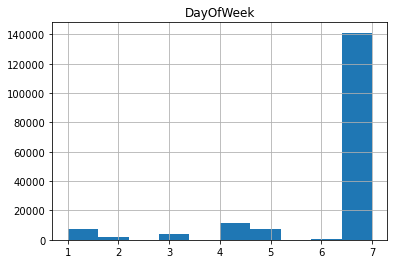

In [10]:
train_store_closed.hist('DayOfWeek');

### Verificando se houve feriado escolar quando a loja estava fechada

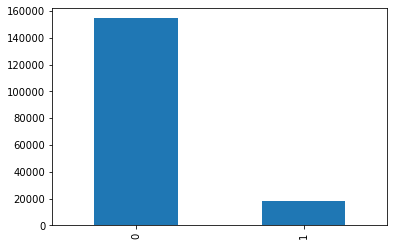

In [11]:
train_store_closed['SchoolHoliday'].value_counts().plot(kind='bar');

### Verificando se houve feriado estadual quando a loja estava fechada

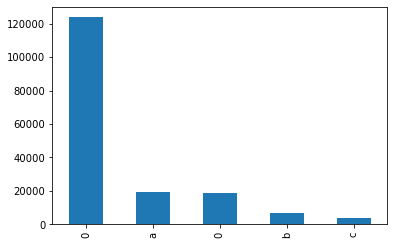

In [12]:
train_store_closed['StateHoliday'].value_counts().plot(kind='bar');

### Checando valores ausentes no conjunto de treino

In [13]:
train.isnull().sum()

Store                   0
DayOfWeek               0
Sales                   0
Customers               0
Open                    0
Promo                   0
StateHoliday            0
SchoolHoliday           0
Year                    0
Month                   0
Day                     0
WeekOfYear              0
SalePerCustomer    172869
dtype: int64

### Contando o número de dias que as lojas estavam fechadas

In [14]:
train[(train.Open == 0)].shape[0]

172817

### Nº de dias em que a loja foi aberta, mas nãou houve venda - pode ser devido a fatores externos ou reformas

In [15]:
train[(train.Open == 1) & (train.Sales == 0)].shape[0]

54

In [16]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Checando valores ausentes no conjunto de dados da loja

In [17]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Faltam apenas 3 observações para 'Distância da concorrência', provavelmente porque os dados não foram inseridos no sistema. Neste caso não há problema em substituir os valores ausentes pela mediana. A mesma abordagem não pode ser utilizada com a presença da concorrência (CompetitionOpen mês e ano), pois não faz sentido. É melhor substituí-lo por 0. Também serão  atribuidos os valores ausentes na promoção com 0, devido a não haver informações disponíveis sobre.


### Substituindo os valores ausentes para a Distância da Concorrência pela mediana

In [18]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

### Substituindo os demais valores ausentes por Zero

In [19]:
store.fillna(0, inplace=True)

In [20]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


### Checando valores ausentes no conjunto de dados de teste

In [21]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

### Assumindo que as lojas estão abertas no conjunto de teste

In [22]:
test.fillna(1, inplace=True)

### Juntando os conjuntos de dados de treino e da loja

In [23]:
train_store_joined = pd.merge(train, store, on='Store', how='inner')
train_store_joined.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### Agrupando as vendas e os clientes entre os tipos de lojas 

In [24]:
# Distribution of sales and customers across store types
train_store_joined.groupby('StoreType')['Customers', 'Sales', 'SalePerCustomer'].sum().sort_values('Sales', ascending=False)

,Customers,Sales,SalePerCustomer
StoreType,,,
a,363541434,3165334859,4.043129e+06
d,156904995,1765392943,2.918350e+06
c,92129705,783221426,9.744876e+05
b,31465621,159231395,7.987612e+04


### Observações de lojas fechadas e sem vendas

In [25]:
train_store_joined[(train_store_joined.Open ==0) | (train_store_joined.Sales==0)].shape

(172871, 22)

Existem 172.871 observações quando as lojas estavam fechadas ou não tiveram vendas. É possível descartar essas linhas para fazer a análise dos dados, mas ainda é necessário mantê-las para modelagem preditiva, devido aos modelos serem capazes de entender a tendência por trás delas.

### Lojas abertas e com vendas > 0

In [26]:
train_store_joined_open = train_store_joined[~((train_store_joined.Open ==0) | (train_store_joined.Sales==0))]
train_store_joined_open.head(5)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### Distribuição de vendas e clientes entre os tipos de lojas

In [27]:
train_store_joined.groupby('StoreType')['Customers', 'Sales', 'SalePerCustomer'].sum().sort_values('Sales', ascending=False)

,Customers,Sales,SalePerCustomer
StoreType,,,
a,363541434,3165334859,4.043129e+06
d,156904995,1765392943,2.918350e+06
c,92129705,783221426,9.744876e+05
b,31465621,159231395,7.987612e+04


Na tabela acima, é possível verificar que as lojas do tipo 'a' e 'd' têm as vendas totais mais altas, mas as lojas do tipo 'c' e 'b' têm a maior venda por cliente.

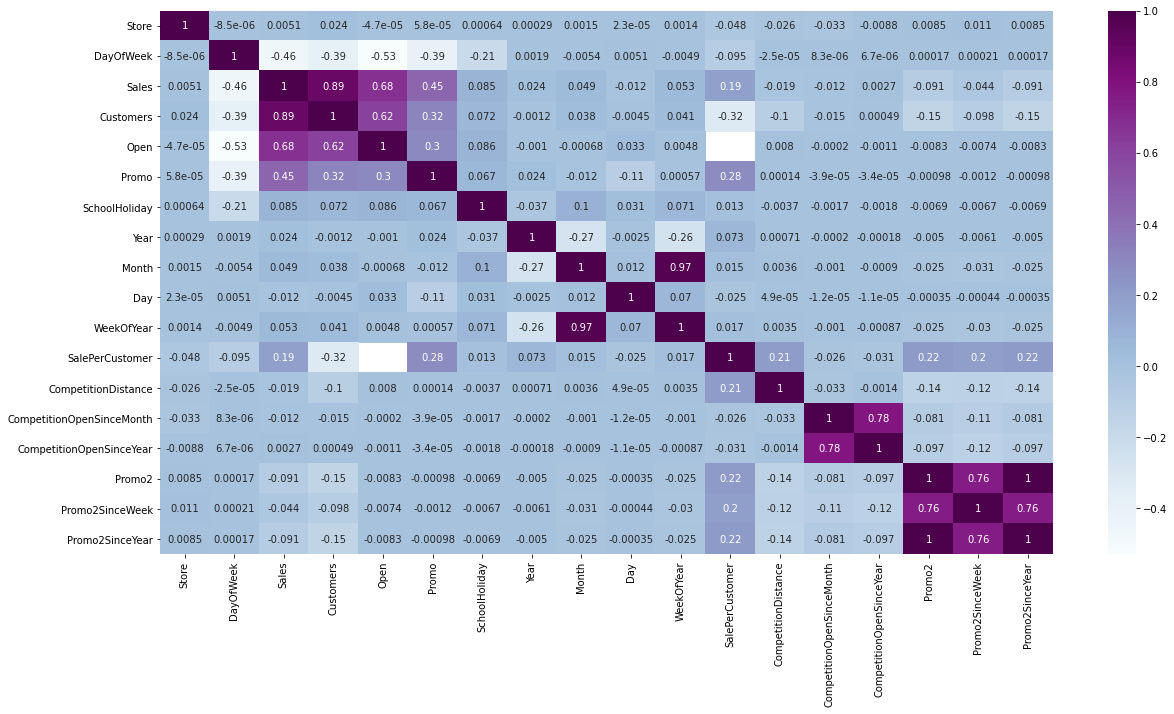

In [28]:
plt.figure(figsize = (20, 10))
sns.heatmap(train_store_joined.corr(), annot=True, cmap='BuPu');

É possível verificar uma forte correlação positiva entre a quantidade de vendas e clientes que visitam a loja. Também é possível observar uma correlação positiva entre uma promoção em execução (promoção = 1) e o número de clientes.

# 1. Tendência & Sazonalidade

Nos gráficos abaixo será possível observar como as vendas variam por mês, promoção, promoção2 (segunda oferta promocional) e por ano.

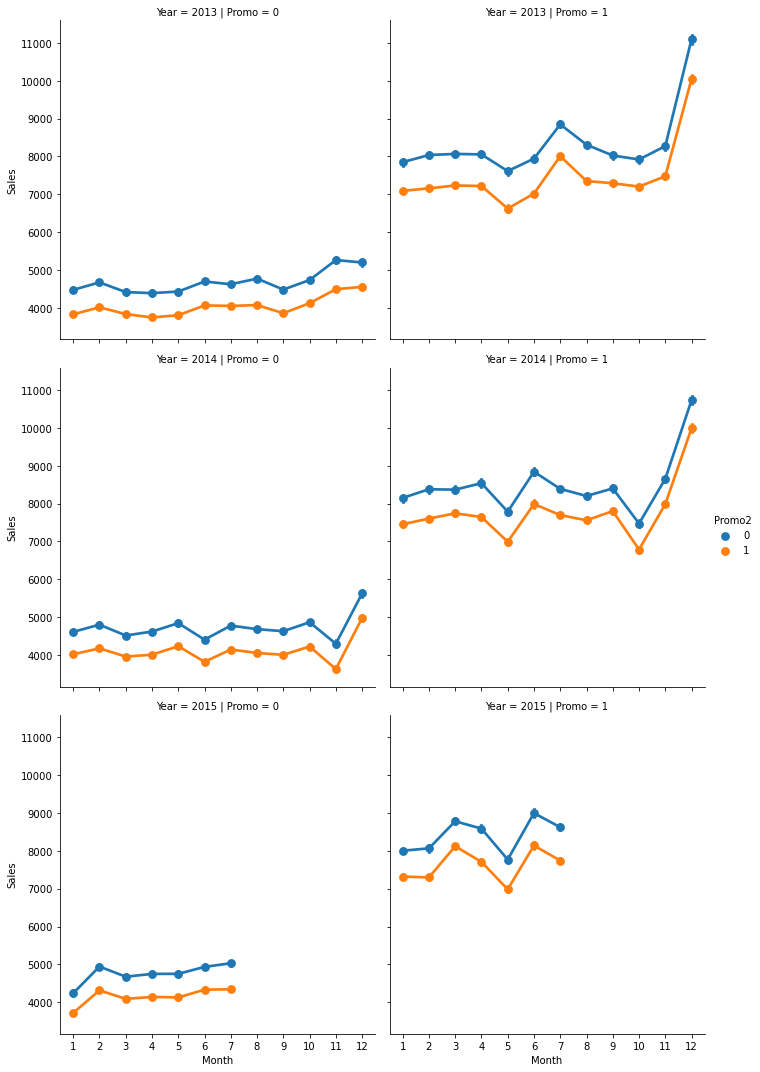

In [29]:
# Sales trend over the months and year
sns.factorplot(data = train_store_joined, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year")

De acordo com os gráficos acima, é possível verificar que as vendas tendem a aumentar no final do ano, o que faz todo sentido devido a sazonalidade do período e, existe um forte incremento nas vendas associadas a promoção, que também acompanha a sazonalidade do período. Portanto, as informações confirmam que as vendas variam com a "Data" (tempo) e há um fator de sazonalidade presente nos dados.

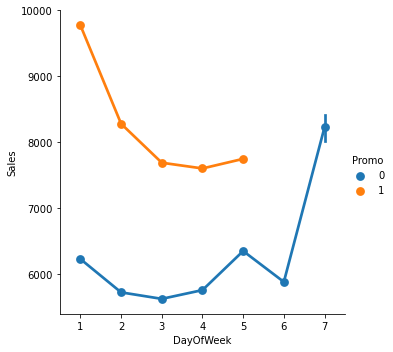

In [30]:
# Sales trend over days
sns.factorplot(data = train_store_joined_open, x = "DayOfWeek", y = "Sales", hue = "Promo");

É possível verificar pela tendência acima que não há promoções nos finais de semana (Promo = 1), pois as lojas buscam obter o maior lucro possível durante o período em que as pessoas saem para fazer as compras de necessidades domésticas.

As vendas tendem a aumentar no domingo e o pico ocorre às segundas-feiras, quando há ofertas promocionais.

# Conclusões sobre a EDA

a) O tipo de loja que mais vende é o A.

b) O tipo de loja B tem o maior ticket médio por cliente.

c) Os clientes costumam comprar mais às segundas-feiras, quando existem ofertas promocionais em andamento, e às quintas / sextas-feiras, quando não há promoção.

d) A segunda promoção (Promo2) parece não contribuir no aumento das vendas.


# 2ª. Parte: Análise de Séries Temporais e Modelagem Preditiva

### Análise de Séries Temporais

Para a Analise de Séries Temporais, será considerado uma loja de cada tipo (a, b, c, d) que representará seu respectivo grupo. Também será necessário reduzir a amostra dos dados, agrupando os dias em semanas e usando o método de nova amostra para ver as tendências atuais com mais clareza.


### Estacionariedade de séries temporais

Para usar os modelos de previsão de séries temporais, é necessario garantir que os dados de séries temporais sejam estacionários, isto é, com média constante, variação constante e covariância constante com o tempo.

Existem duas maneiras de testar a estacionariedade das séries temporais:

a) Média móvel: uma análise contínua de um modelo de série temporal é frequentemente usada para avaliar a estabilidade do modelo ao longo do tempo. A janela é rolada (deslizada pelos dados) semanalmente, na qual a média é calculada semanalmente. Rolling Statistics é um teste de visualização, onde podemos comparar os dados originais com os dados rolados e verificar se os dados estão estacionários ou não.

b) Teste de Dicky-Fuller: Esse teste nos fornece dados estatísticos, como valor-p, para entender se podemos rejeitar a hipótese nula. A hipótese nula é que os dados não são estacionários e a hipótese alternativa diz que os dados são estacionários. Se o valor p for menor que o valor crítico (por exemplo, 0,5), rejeitaremos a hipótese nula e diremos que os dados são estacionários.

Agora será verificada a estacionariedade das lojas de acordo com seus tipos (a, b, c e d):

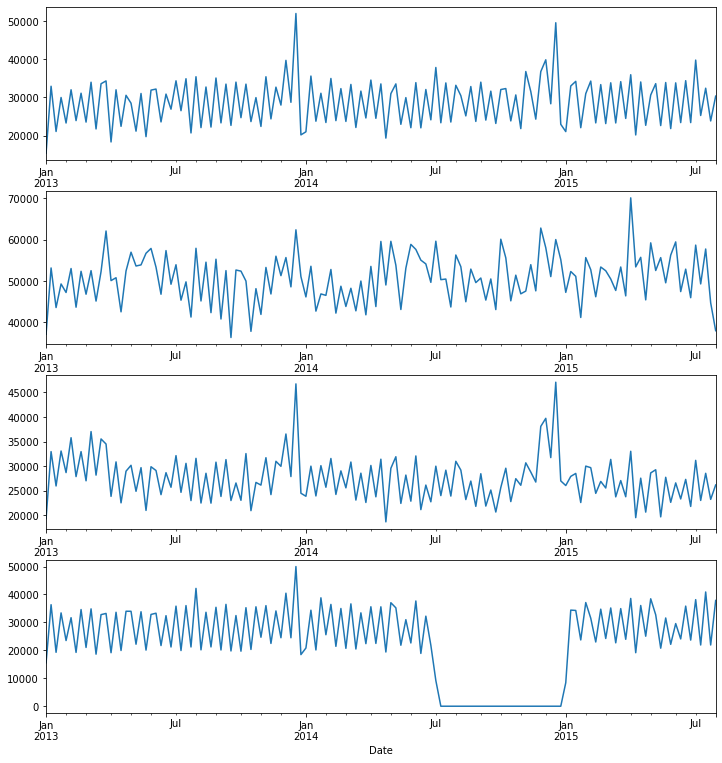

In [31]:
train['Sales'] = train['Sales'] * 1.0

sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) 
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4);

É possível verificar que as vendas nos gráficos acima, para os tipos de loja A e C, tendem a atingir o pico no final do ano (época de Natal) e depois diminuem após os feriados. Não é possível identificar a mesma tendência na loja de tipo D porque não há dados disponíveis para esse período (lojas fechadas).

In [32]:
def test_stationarity(timeseries):
    
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    fig, ax = plt.subplots()
    fig.set_size_inches(17, 5)
    orig = plt.plot(timeseries.resample('W').mean(), color='red',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='blue', label='Média Móvel')
    std = plt.plot(roll_std.resample('W').mean(), color='black', label = 'Desvio Padrão Móvel')
    plt.legend(loc='best')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)

### Testando a estacionariedade da loja do tipo A

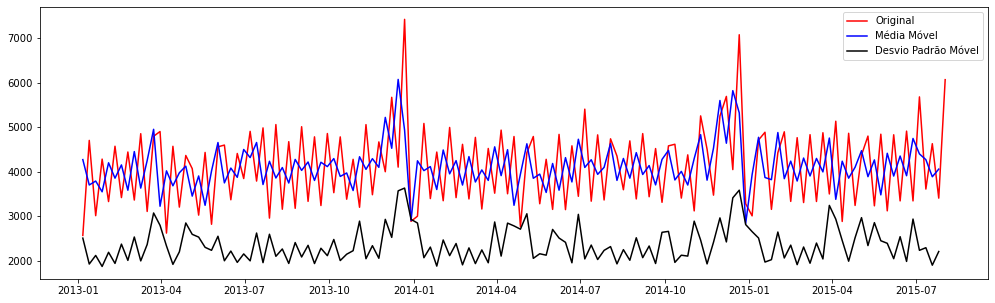

Results of Dickey-Fuller Test:
ADF Statistic: -6.218237
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [33]:
test_stationarity(sales_a)

### Testando a estacionariedade da loja do tipo B

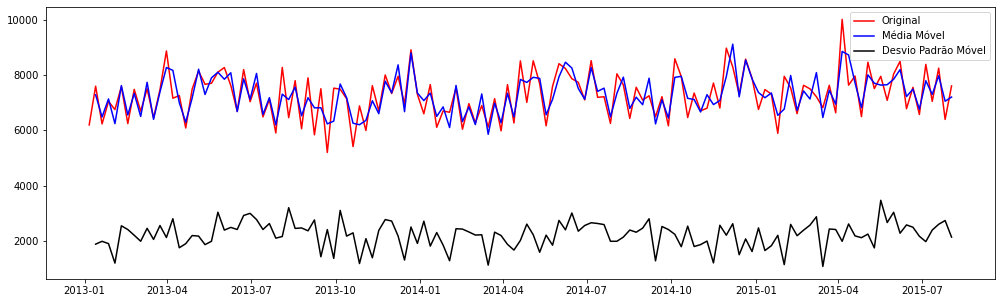

Results of Dickey-Fuller Test:
ADF Statistic: -5.660918
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [34]:
test_stationarity(sales_b)

### Testando a estacionariedade da loja do tipo C

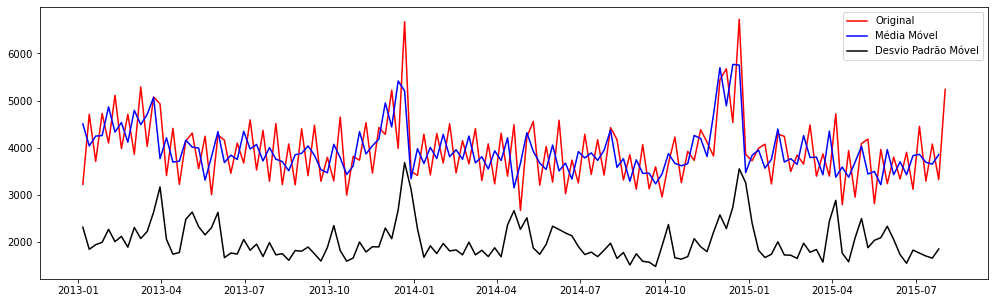

Results of Dickey-Fuller Test:
ADF Statistic: -4.374784
p-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [35]:
test_stationarity(sales_c)

### Testando a estacionariedade da loja do tipo D

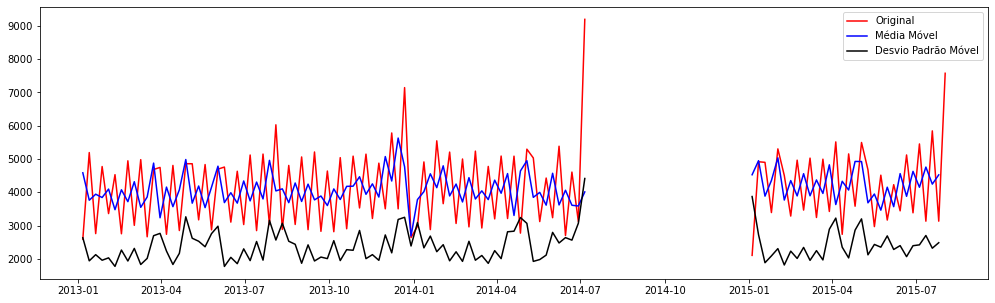

Results of Dickey-Fuller Test:
ADF Statistic: -6.237461
p-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [36]:
test_stationarity(sales_d)

### Verificando a estacionariedade nos dados de todos os tipos da lojas juntos.

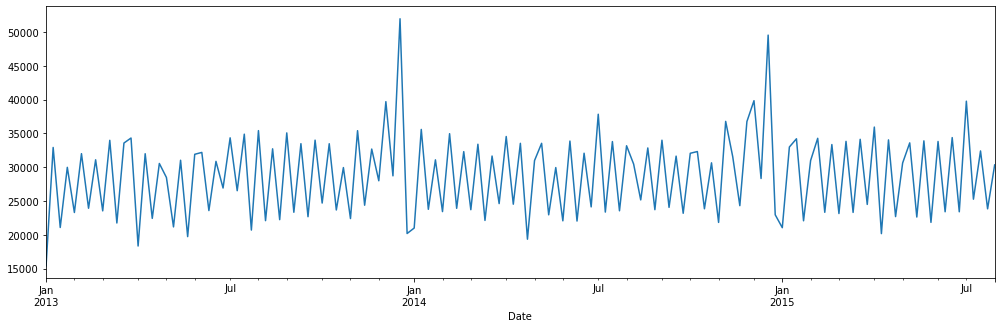

In [37]:
# Data Preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# Assigning one store from each category
sales_a = train[train.Store == 2]['Sales']

f, (ax1) = plt.subplots(1, figsize = (17, 5))

# Trend
sales_a.resample('W').sum().plot(ax = ax1)

O gráfico acima indica que as vendas tendem a atingir o pico no fim do ano.

### Agora, será verificado a tendência e a sazonalidade nos dados de acordo com o tipo da loja.

In [38]:
def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=365)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    axes[1].plot(estimated_seasonal, 'g', label='Sazonalidade')
    axes[1].legend(loc='upper left');
    
    axes[0].plot(estimated_trend, label='Tendência')
    axes[0].legend(loc='upper left');

    plt.title('Gráficos de decomposição')

### Plotando a sazonalidade e a tendência para a loja do tipo A

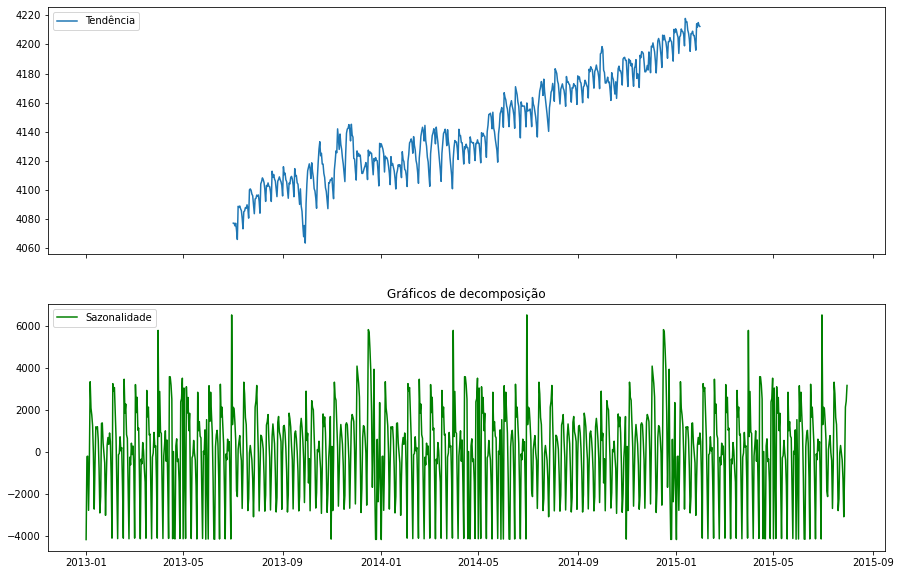

In [39]:
plot_timeseries(sales_a,'a')

### Plotando a sazonalidade e a tendência para a loja do tipo B

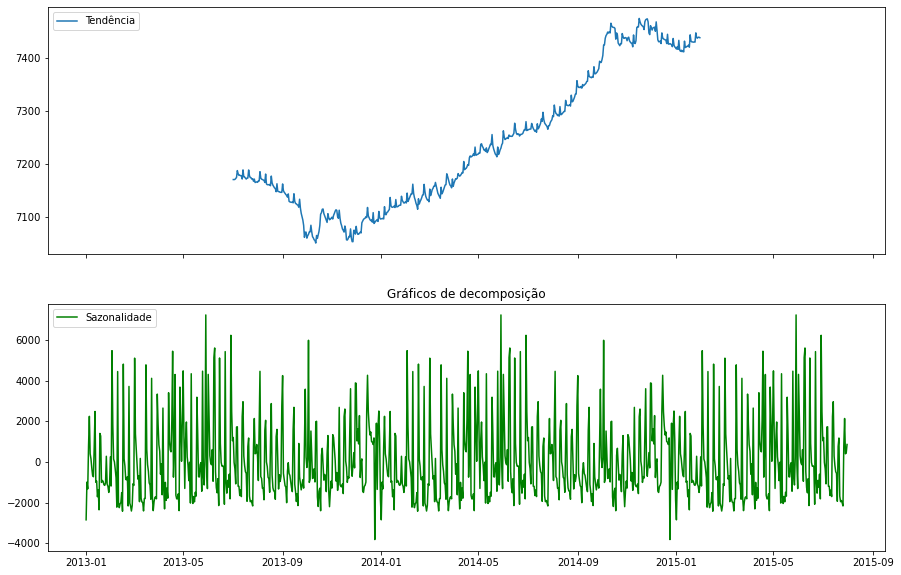

In [40]:
plot_timeseries(sales_b,'b')

### Plotando a sazonalidade e a tendência para a loja do tipo C

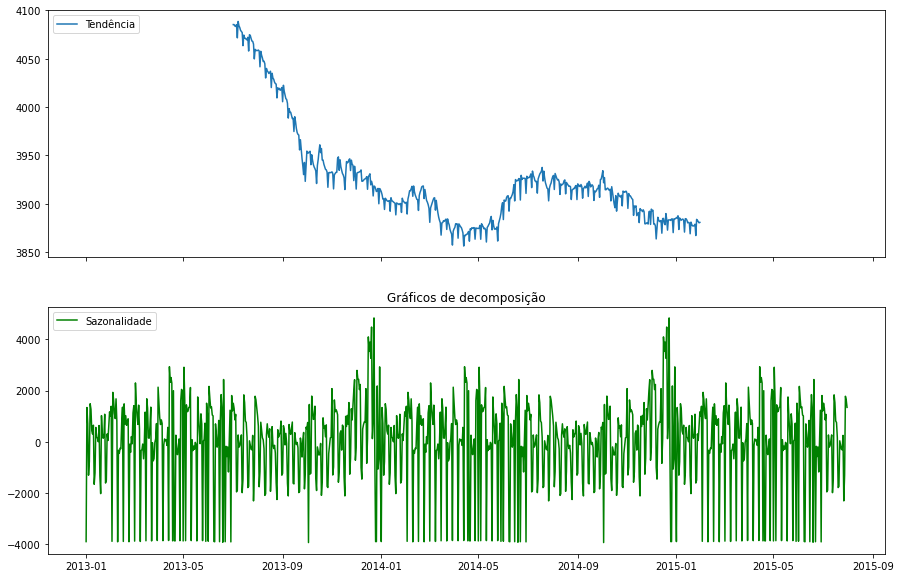

In [41]:
plot_timeseries(sales_c,'c')

### Plotando a sazonalidade e a tendência para a loja do tipo D

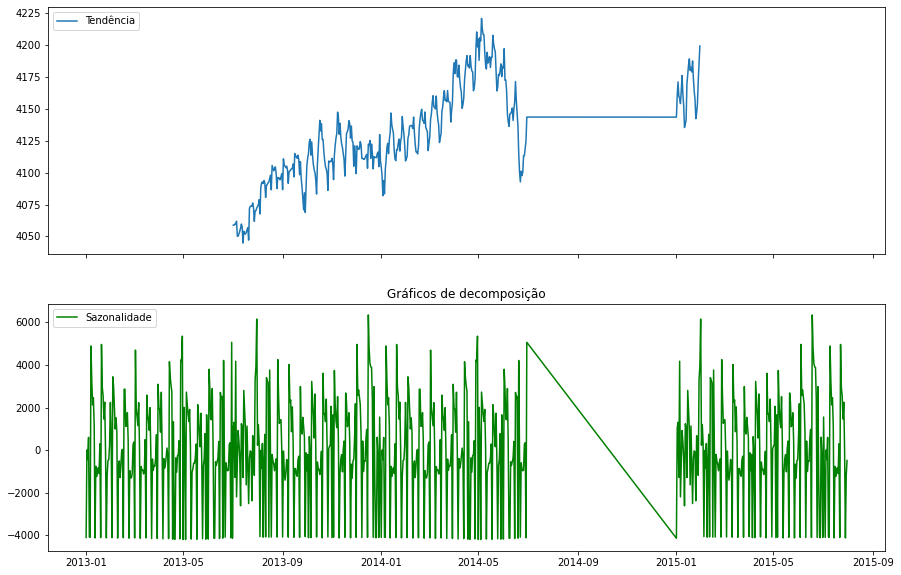

In [42]:
plot_timeseries(sales_d,'d')

É possível verificar através dos gráficos e testes estatísticos acima que a média e a variação não mudam muito com o tempo, ou seja, são constantes.
Portanto, não será necessário realizar nenhuma transformação (necessária quando as séries temporais não são estacionárias).

A partir das analises realizadas, é possível concluir que há sazonalidade e tendência presentes em nos dados. Portanto, serão usados modelos de previsão que levam esses dois fatores em consideração. Por exemplo, como já mencionado no início do notebook, SARIMAX, Prophet e XGBoost.

# Previsão de uma série temporal

### Métricas de Avaliação

Existem duas métricas populares usadas na medição do desempenho de modelos de regressão (variável contínua), ou seja, MAE e RMSE.

MAE - Erro absoluto médio: é a média da diferença absoluta entre os valores previstos e os valores observados.

RMSE - Erro médio quadrático da raiz: é a raiz quadrada da média das diferenças quadráticas entre os valores previstos e os valores observados.

O MAE é mais fácil de entender e interpretar, mas o RMSE funciona bem em situações em que grandes erros são indesejáveis. Isso ocorre porque os erros são elevados ao quadrado antes da média, penalizando grandes erros. Neste caso, o RMSE se adapta bem, porque o objetivo é prever prever as vendas com erro mínimo (isto é, penalizar erros altos), para que o inventário possa ser gerenciado adequadamente.

Então, o RMSE será escolhido como uma métrica para medir o desempenho dos modelos.

### Modelo 1 - SARIMA (média móvel integrada autoregressiva sazonal)

Para usar esse modelo, é necessário primeiro descobrir os valores de p, d e q. p representa o número de termos autorregressivos - atrasos da variável dependente. q representa o número de termos da média móvel - erros de previsão atrasados ​​na equação de previsão. d representa o número de diferenças não sazonais.

Para encontrar os valores de p, d e q - será usado gráficos de função de autocorrelação (ACF) e autocorrelação parcial (PACF).

ACF - medida de correlação entre séries temporais com uma versão atrasada de si mesma. 
PACF - medida de correlação entre séries temporais com uma versão defasada de si mesma, mas após eliminar as variações já explicadas pela comparação intermediária.

p value é o valor no eixo x do PACF em que o gráfico cruza o intervalo de confiança superior pela primeira vez. q value é o valor no eixo x do ACF em que o gráfico cruza o intervalo de confiança superior pela primeira vez.

Agora, serão traçados os gráficos.

In [43]:
# Autocorrelation function to make ACF and PACF graphs
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('ACF')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('PACF')

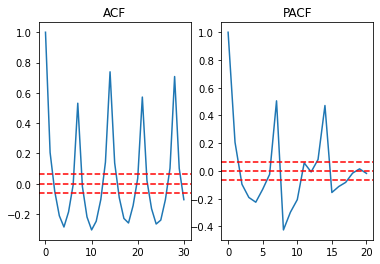

In [44]:
# ACF and PACF for store type a
auto_corr(sales_a)

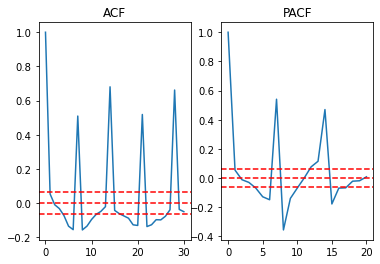

In [45]:
# ACF and PACF for store type b
auto_corr(sales_b)

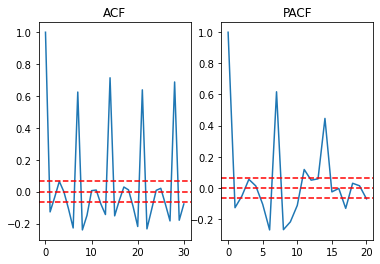

In [46]:
# ACF and PACF for store type c
auto_corr(sales_c)

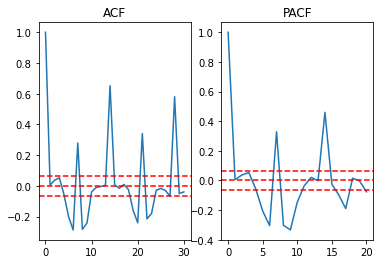

In [47]:
# ACF and PACF for store type d
auto_corr(sales_d)

Os gráficos acima sugerem que p = 2 e q = 2, mas será feita uma pesquisa em grade para ver qual combinação de p, q e d fornece o menor critério de informação de Akaike (AIC, que nos informa a qualidade dos modelos estatísticos para um determinado conjunto) O melhor modelo usa o menor número de recursos para ajustar os dados.

Para prever as vendas de cada loja, é necessário considerar todo o conjunto de dados em vez de uma loja de cada categoria. Será utilizado um repositório de cada categoria para entender os dados da série de tempos, mas a partir de agora, será utilizado todo o conjunto de dados para a modelagem.

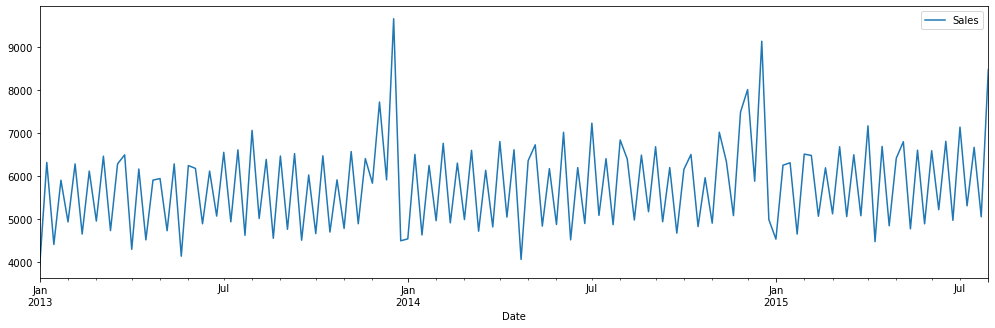

In [48]:
# Summing sales on per week basis
train_arima = train.resample("W").mean() 
train_arima = train_arima[["Sales"]]
train_arima.plot(figsize=(17,5));

### Modelo ARIMA de ajuste de hiperparâmetro

Como mencionado acima, existem três parâmetros (p, d e q) para o modelo SARIMA. Portanto, para escolher a melhor combinação desses parâmetros, será usada uma pesquisa em grade. A melhor combinação de parâmetros fornecerá a pontuação mais baixa da AIC.


In [49]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Agora, vamos percorrer essas combinações para ver qual delas apresenta a menor pontuação na AIC.

In [50]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2708.8196371542945
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2357.203980769066
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2142.9121481207662
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1893.8220522805514
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2163.0856692797665
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2116.705791323771
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1919.9439695857754
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1894.952410634116
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2592.3366943406054
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2305.8868305053825
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2103.017189110138
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1856.6353258997985
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2146.042617151302
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2066.9087481616457
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1902.4415089776214
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1852.884184249761
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2368.481953362583
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2154.58045331046
A

É possível verificar na pesquisa de grade acima que a combinação ideal de parâmetros é ARIMA (1, 1, 1) x (0, 1, 1, 12) 12 - AIC: 1806.2981906705384. Então será usada em nosso modelo.

### Ajustando o modelo - usando hiperparâmetros ajustados acima

In [51]:
# Fitting the data to SARIMA model 
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_sarima = model_sarima.fit()

print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5251      0.103     -5.091      0.000      -0.727      -0.323
ma.L1         -0.9559      0.050    -19.078      0.000      -1.054      -0.858
ma.S.L12      -1.0120      0.831     -1.218      0.223      -2.640       0.616
sigma2      8.268e+05   7.31e+05      1.131      0.258   -6.06e+05    2.26e+06


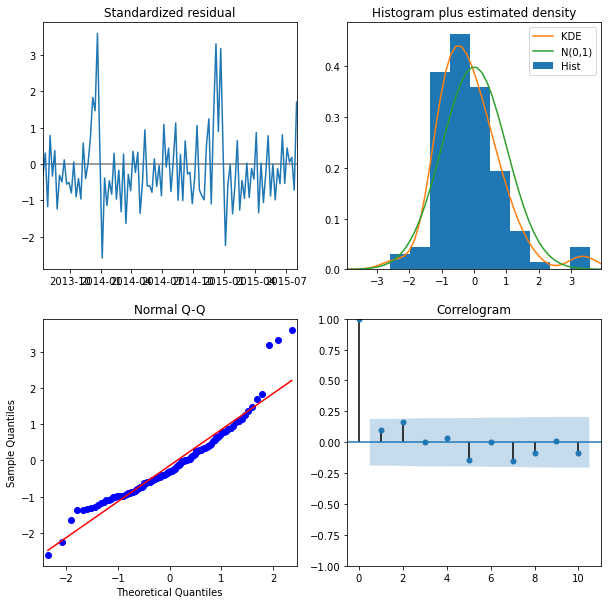

In [52]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()

É possivel verificar no gráfico 'Histograma mais densidade estimada' acima, que o gráfico do KDE (Kernel Desnity Estimator) segue de perto o gráfico de distribuição normal N (0,1). O gráfico Q-Q normal mostra que a distribuição ordenada de resíduos segue a distribuição semelhante à distribuição normal. Assim, o modelo parece ser ideal.

A plotagem residual padronizada revela que não há uma grande tendência de sazonalidade, o que é confirmado pela plotagem Correlogram (autocorrelation). O gráfico de autocorrelação diz que os resíduos das séries temporais têm baixa correlação com versões atrasadas de si mesmas.

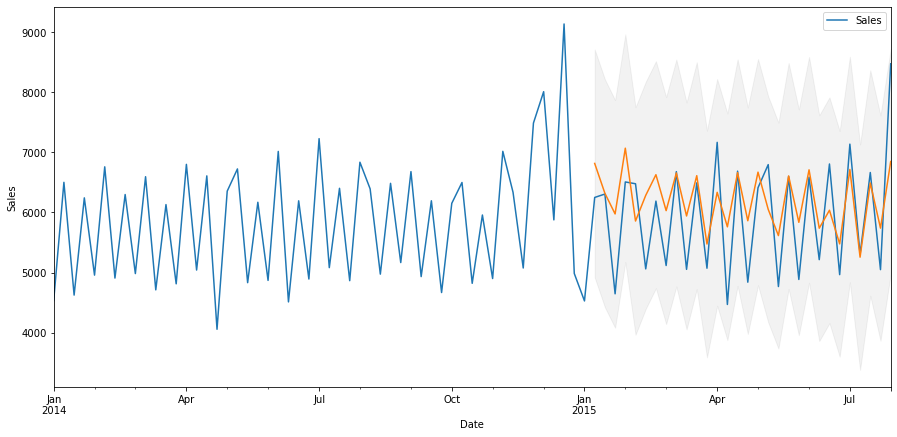

Root Mean Squared Error:  739.0647144827332


In [53]:
# Model Prediction and validation 
# Predictions are performed for the 11th Jan' 2015 onwards of the train data.

pred = results_sarima.get_prediction(start=pd.to_datetime('2015-01-11'), dynamic = False) 

# Get confidence intervals of forecasts
pred_ci = pred.conf_int() 

ax = train_arima["2014":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima["2015-01-11":]

# Calculating the error
rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

### Solução final ARIMA:

Foram testadas diferentes combinações de parâmetros usando a pesquisa em grade e o parâmetro ideal: ARIMA (1, 1, 1) x (0, 1, 1, 12) 12 - AIC: 1806.29. Vamos tentar outro modelo para ver se podemos reduzir o erro.

## Modelo 2 - Prophet

In [54]:
# Creating a train dataset
train_prophet = train.copy()
train_prophet.reset_index(level=0, inplace=True)

In [55]:
# Converting col names to specific names as required by Prophet library
train_prophet = train_prophet.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
train_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   ds               1017209 non-null  datetime64[ns]
 1   Store            1017209 non-null  int64         
 2   DayOfWeek        1017209 non-null  int64         
 3   y                1017209 non-null  float64       
 4   Customers        1017209 non-null  int64         
 5   Open             1017209 non-null  int64         
 6   Promo            1017209 non-null  int64         
 7   StateHoliday     1017209 non-null  object        
 8   SchoolHoliday    1017209 non-null  int64         
 9   Year             1017209 non-null  int64         
 10  Month            1017209 non-null  int64         
 11  Day              1017209 non-null  int64         
 12  WeekOfYear       1017209 non-null  int64         
 13  SalePerCustomer  844340 non-null   float64       
dtypes:

In [56]:
# Downsampling to week because modelling on daily basis takes a lot of time
ts_week_prophet_train = train_prophet.set_index("ds").resample("W").sum()
ts_week_prophet_train.head()

,Store,DayOfWeek,y,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
ds,,,,,,,,,,,,
2013-01-06,3732032,30103,26129335.0,3110602,4471,0,4533,13464957,6689,23414,6689,39406.143319
2013-01-13,4355190,31220,49275222.0,5226350,6649,5575,560,15711465,7805,78050,15610,65076.326540
2013-01-20,4355190,31220,34377765.0,4205743,6654,0,0,15711465,7805,132685,23415,57208.229656
2013-01-27,4355190,31220,46040169.0,4928833,6665,5575,0,15711465,7805,187320,31220,65073.831993
2013-02-03,4355190,31220,38466029.0,4507650,6667,0,128,15711465,11150,138260,39025,59686.174407


In [57]:
ts_week_prophet_train = ts_week_prophet_train.reset_index()
ts_week_prophet_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ds               135 non-null    datetime64[ns]
 1   Store            135 non-null    int64         
 2   DayOfWeek        135 non-null    int64         
 3   y                135 non-null    float64       
 4   Customers        135 non-null    int64         
 5   Open             135 non-null    int64         
 6   Promo            135 non-null    int64         
 7   SchoolHoliday    135 non-null    int64         
 8   Year             135 non-null    int64         
 9   Month            135 non-null    int64         
 10  Day              135 non-null    int64         
 11  WeekOfYear       135 non-null    int64         
 12  SalePerCustomer  135 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(10)
memory usage: 13.8 KB


### Modelo Inicial / Linha Base Prophet

In [58]:
# Fitting data to Prophet model
prophet_1 = Prophet() 
prophet_1.fit(ts_week_prophet_train)

future_1 = prophet_1.make_future_dataframe(periods = 52, freq = "W") 
forecast_1 = prophet_1.predict(future_1)

forecast_1[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
182,2016-07-03,4.445966e+07,3.521537e+07,5.403045e+07
183,2016-07-10,4.410727e+07,3.515588e+07,5.388149e+07
184,2016-07-17,4.435072e+07,3.472744e+07,5.414962e+07
185,2016-07-24,4.423817e+07,3.422594e+07,5.384032e+07
186,2016-07-31,4.344665e+07,3.314111e+07,5.261138e+07


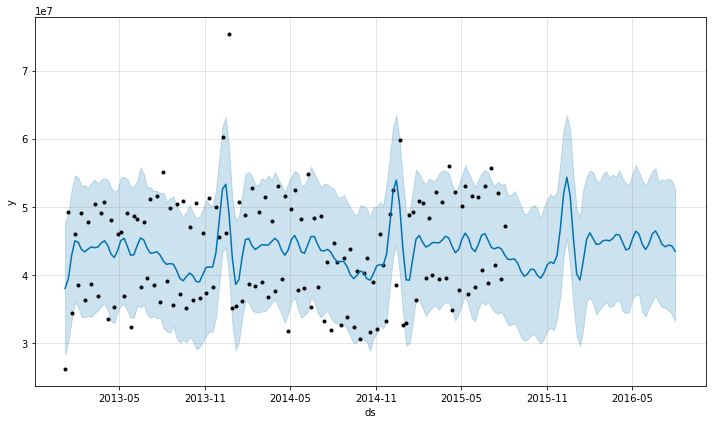

In [59]:
# Visualizing predicions of forecast
prophet_1.plot(forecast_1);

In [60]:
# Checking the RMSE of Prophet model
metric_prophet_1 = forecast_1.set_index('ds')[['yhat']].join(ts_week_prophet_train.set_index('ds').y).reset_index()
metric_prophet_1.dropna(inplace=True)
rms_prophet_1 = mean_squared_error(metric_prophet_1.y, metric_prophet_1.yhat)
rms_prophet_1

53782649094881.14

Agora a tentativa de reduzir o erro.

### Modelo Prophet com Hipertensão

Existem muitos parâmetros disponíveis no modelo Prophet. Um dos mais importantes são os feriados. Isso permite passar feriados explicitamente enquanto o modelo é treinado. Será criado um novo quadro de dados de 'feriados', fazendo observações quando houve feriado escolar ou estadual.

Também será usado mais três parâmetros de vizualização.

 - interval_width: define o nível de incerteza para fazer a previsão. O valor padrão é 0,8, mas será usado 0,95 para certificar as previsões.
 - growth: as 'Vendas' podem ter qualquer valor e não há ponto de saturação. Então, será utilizado crescimento 'linear' em vez de 'logarítmico'.
 - yearly_seasonality: será passado explicitamente como 'True' porque existe uma sazonalidade anual (discutida acima) presente em nos dados.

In [61]:
# Encoding state holiday categorical variable
train_prophet["StateHoliday_cat"] = train_prophet["StateHoliday"].map({0:0, "0": 0, "a": 1, "b": 1, "c": 1})

In [62]:
# Choosing only required cols
train_prophet = train_prophet[['ds', 'y', 'SchoolHoliday', 'StateHoliday_cat']]
train_prophet.head()

,ds,y,SchoolHoliday,StateHoliday_cat
0,2015-07-31,5263.0,1,0
1,2015-07-31,6064.0,1,0
2,2015-07-31,8314.0,1,0
3,2015-07-31,13995.0,1,0
4,2015-07-31,4822.0,1,0


In [63]:
# Modelling holidays - creating holidays dataframe
state_dates = train_prophet[(train_prophet.StateHoliday_cat == 1)].loc[:, "ds"].values
school_dates = train_prophet[(train_prophet.SchoolHoliday == 1)].loc[:, "ds"].values

state = pd.DataFrame({"holiday": "state_holiday",  "ds": pd.to_datetime(state_dates)})
school = pd.DataFrame({"holiday": "school_holiday", "ds": pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [64]:
# Dropping holiday columns because not needed any more
train_prophet_clean = train_prophet.drop(["SchoolHoliday", "StateHoliday_cat"], axis = 1)
train_prophet_clean.head()

,ds,y
0,2015-07-31,5263.0
1,2015-07-31,6064.0
2,2015-07-31,8314.0
3,2015-07-31,13995.0
4,2015-07-31,4822.0


In [65]:
# Downsampling to week because modelling on daily basis takes a lot of time
ts_week_prophet = train_prophet_clean.set_index("ds").resample("W").sum()
ts_week_prophet.head()

,y
ds,
2013-01-06,26129335.0
2013-01-13,49275222.0
2013-01-20,34377765.0
2013-01-27,46040169.0
2013-02-03,38466029.0


In [66]:
# Resetting the index
ts_week_prophet_train = ts_week_prophet.reset_index()
ts_week_prophet_train.head()

,ds,y
0,2013-01-06,26129335.0
1,2013-01-13,49275222.0
2,2013-01-20,34377765.0
3,2013-01-27,46040169.0
4,2013-02-03,38466029.0


In [67]:
# Fitting data to Prophet model
prophet_2 = Prophet(holidays = holidays, interval_width = 0.95, growth='linear', yearly_seasonality = True) 
prophet_2.fit(ts_week_prophet_train)
print("done")

future_2 = prophet_2.make_future_dataframe(periods = 52, freq = "W") 
forecast_2 = prophet_2.predict(future_2)

forecast_2[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail() # We have a new dataframe, which includes, the forecast and the uncertainity invervals.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


done


,ds,yhat,yhat_lower,yhat_upper
182,2016-07-03,4.414438e+07,3.026317e+07,5.792995e+07
183,2016-07-10,4.383894e+07,2.982884e+07,5.725598e+07
184,2016-07-17,4.410799e+07,2.984621e+07,5.841544e+07
185,2016-07-24,4.412114e+07,2.948724e+07,5.789214e+07
186,2016-07-31,4.352276e+07,2.987607e+07,5.856051e+07


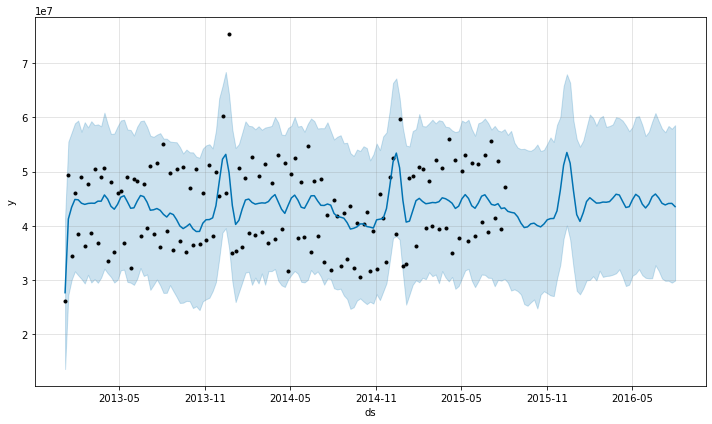

In [68]:
# Visualizing predicions of forecast
prophet_2.plot(forecast_2);

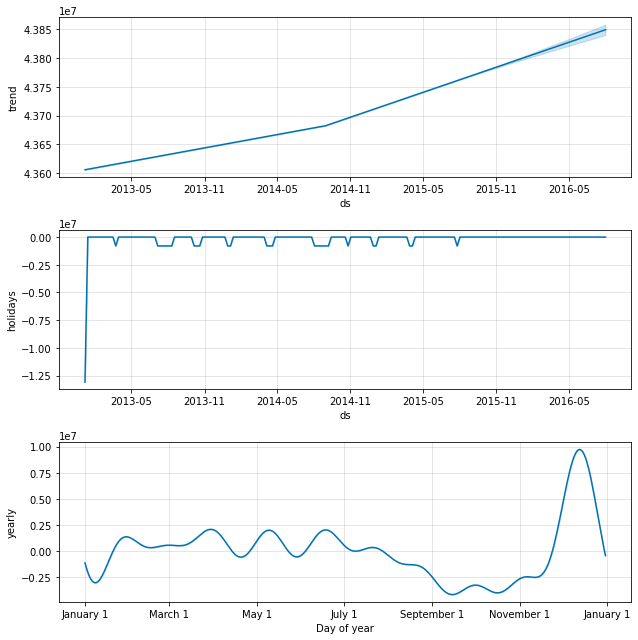

In [69]:
# Visualizing trend and seasonality components
prophet_2.plot_components(forecast_2);

O primeiro gráfico mostra que o total de vendas semanalmente está aumentando. O segundo gráfico mostra as lacunas de feriado no conjunto de dados e o terceiro gráfico mostra que a loja tem vendas muito altas na última semana de dezembro (devido às férias de Natal).

In [70]:
# Checking the RMSE of Prophet model
metric_prophet_2 = forecast_2.set_index('ds')[['yhat']].join(ts_week_prophet_train.set_index('ds').y).reset_index()
metric_prophet_2.dropna(inplace=True)
rms_prophet_2 = mean_squared_error(metric_prophet_2.y, metric_prophet_2.yhat)
rms_prophet_2

52478331938232.15

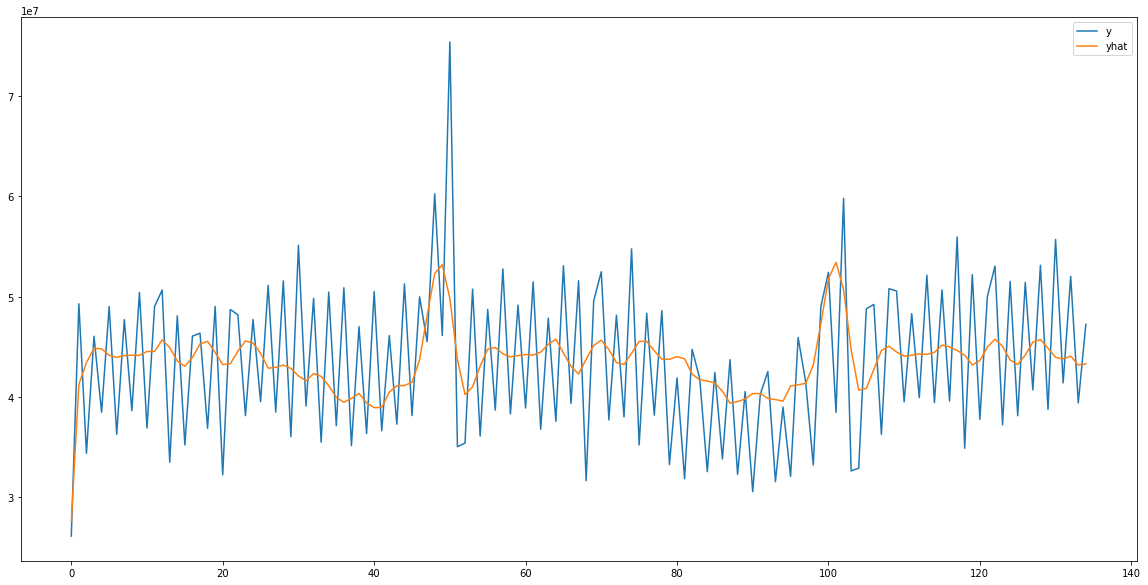

In [71]:
# Visualizing the performance of model
plt.figsize=(10,20)
metric_prophet_2["y"].plot(figsize=(20,10))
metric_prophet_2["yhat"].plot()
plt.legend()
plt.show()

### Modelo Prophet Final:

Nosso modelo de linha de base do Profeta usou parâmetros padrão e obtivemos o RMSE de 53782649094881.14 e, após hiper-ajuste, obtivemos o RMSE de 52478331938232.15. Embora o modelo final tenha um desempenho melhor, ele ainda apresenta um desempenho ruim em comparação com o ARIMA. Então, vamos tentar outro modelo.

## Modelo 3 - XGBoost

Precisamos converter todas as variáveis categóricas em variáveis numéricas / fictícias para implementar o XGBoost. Também removeremos colunas correlacionadas (por exemplo, Clientes, Venda por cliente), além de mesclar colunas semelhantes em uma coluna (CompetitionOpenSinceMonth, CompetitionOpenSinceYear).

In [72]:
# Dropping Customers and Sale per customer
ts_xgboost = train_store_joined.copy()
ts_xgboost = ts_xgboost.drop(['Customers', 'SalePerCustomer', 'PromoInterval'], axis=1)

In [73]:
# Combining similar columns into one column and dropping old columns
ts_xgboost['CompetitionOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.CompetitionOpenSinceYear) + (ts_xgboost.Month - ts_xgboost.CompetitionOpenSinceMonth)
ts_xgboost['PromoOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.Promo2SinceYear) + (ts_xgboost.WeekOfYear - ts_xgboost.Promo2SinceWeek) / 4.0
ts_xgboost = ts_xgboost.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)
ts_xgboost = ts_xgboost.drop(["Promo2SinceWeek", "Promo2SinceYear"], axis = 1)

In [74]:
# Converting categorical cols to numerical cols and removing old cols
mappings = {0:0, "0": 0, "a": 1, "b": 1, "c": 1}
ts_xgboost["StateHoliday_cat"] = ts_xgboost["StateHoliday"].map(mappings)
ts_xgboost["StoreType_cat"] = ts_xgboost["StoreType"].map(mappings)
ts_xgboost["Assortment_cat"] = ts_xgboost["Assortment"].map(mappings)
ts_xgboost = ts_xgboost.drop(["StateHoliday", "StoreType", "Assortment"], axis = 1)

In [75]:
# Splitting the data
features = ts_xgboost.drop(["Sales"], axis = 1)
target = ts_xgboost["Sales"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.20)

### Modelo Inicial / Linha Base XGBoost

In [76]:
# Tuning parameters - using default metrics
params = {'max_depth':6, "booster": "gbtree", 'eta':0.3, 'objective':'reg:linear'} 

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost = xgb.train(params, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds = xgboost.predict(dtest)

[21:53:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5165.36279	eval-rmse:5158.65918
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:4014.29858	eval-rmse:4007.16162
[2]	train-rmse:3298.22534	eval-rmse:3292.39966
[3]	train-rmse:2880.16284	eval-rmse:2874.73291
[4]	train-rmse:2641.58862	eval-rmse:2637.25391
[5]	train-rmse:2508.37549	eval-rmse:2505.27393
[6]	train-rmse:2435.68384	eval-rmse:2433.13989
[7]	train-rmse:2352.94849	eval-rmse:2350.20850
[8]	train-rmse:2328.17041	eval-rmse:2325.59619
[9]	train-rmse:2296.28101	eval-rmse:2293.22656
[10]	train-rmse:2276.19189	eval-rmse:2274.03418
[11]	train-rmse:2253.39111	eval-rmse:2251.47314
[12]	train-rmse:2241.14404	eval-rmse:2239.84741
[13]	train-rmse:2206.81152	eval-rmse:2205.60449
[14]	train-rmse:2

In [77]:
# RMSE of model
rms_xgboost = sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error for XGBoost:", rms_xgboost)

Root Mean Squared Error for XGBoost: 1238.9394922637005


## Hypertuning XGBoost

Agora vamos tentar diminuir o RMSE do XGBoost passando valores diferentes para nossos hiperparâmetros no modelo XGBoost.

   - eta: define a taxa de aprendizado, ou seja, o tamanho da etapa para aprender os dados na modelagem de descida de gradiente (a base do XGBoost). O valor padrão é 0,3, mas queremos manter a taxa de aprendizado baixa para evitar ajustes excessivos. Então, vamos escolher 0.2 como eta
   - max_depth: profundidade máxima de uma árvore. O valor padrão é 6, mas queremos que nosso modelo seja mais complexo e encontre boas previsões. Então, vamos escolher 10 como profundidade máxima.
   - gama: Redução de perda mínima necessária para criar uma partição adicional em um nó folha da árvore. Quanto maior a gama, mais conservador será o algoritmo. O valor padrão é 0, vamos escolher um valor um pouco mais alto para obter boas previsões


In [78]:
# Tuning parameters
params_2 = {'max_depth':10, 'eta':0.1,  'gamma': 2}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost_2 = xgb.train(params_2, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds_2 = xgboost_2.predict(dtest)

[0]	train-rmse:6325.38916	eval-rmse:6319.39307
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:5778.75439	eval-rmse:5772.95752
[2]	train-rmse:5291.65772	eval-rmse:5286.01172
[3]	train-rmse:4862.73096	eval-rmse:4857.69141
[4]	train-rmse:4482.45068	eval-rmse:4478.10547
[5]	train-rmse:4148.67920	eval-rmse:4144.86914
[6]	train-rmse:3852.67432	eval-rmse:3849.32764
[7]	train-rmse:3595.28174	eval-rmse:3592.37500
[8]	train-rmse:3371.40894	eval-rmse:3369.21875
[9]	train-rmse:3175.82251	eval-rmse:3174.11499
[10]	train-rmse:3004.71533	eval-rmse:3003.88623
[11]	train-rmse:2861.61841	eval-rmse:2861.57324
[12]	train-rmse:2737.85425	eval-rmse:2738.62402
[13]	train-rmse:2632.10400	eval-rmse:2634.07324
[14]	train-rmse:2536.77979	eval-rmse:2539.60571
[15]	train-rmse:2461.84375	eval-rmse:2465.66260
[16]	train-rmse:2380.15283	eval-rmse:2385.00586
[17]	train-rmse:2322.04834	eval-rmse:2327.81592
[1

In [79]:
# RMSE of model
rms_xgboost_2 = sqrt(mean_squared_error(y_test, preds_2))
print("Root Mean Squared Error for XGBoost:", rms_xgboost_2)

Root Mean Squared Error for XGBoost: 1218.490769189985


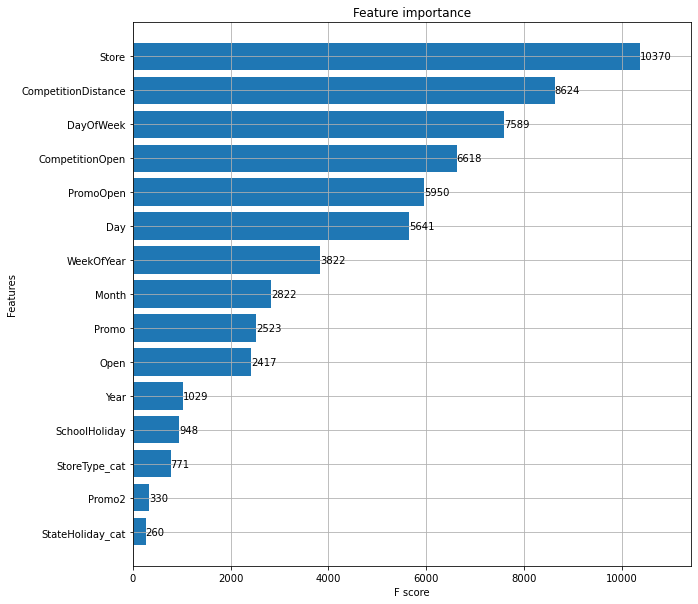

In [80]:
# Let's see the feature importance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgboost_2, max_num_features=50, height=0.8, ax=ax)
plt.show()

## Modelo Final XGBoost:

Após o hypertuning, conseguimos reduzir o RMSE de 1226,99 para 1191,90, o que é ótimo! 
Agora, vamos comparar o desempenho de todos os modelos

## Resultados

In [81]:
# Comparing performance of above three models - through RMSE
rms_arima = format(float(rms_arima))
rms_prophet_2 = format(float(rms_prophet_2))
rms_xgboost_2 = format(float(rms_xgboost_2))

model_errors = pd.DataFrame({
    "Model": ["SARIMA", "Prophet", "XGBoost"],
    "RMSE": [rms_arima, rms_prophet_2, rms_xgboost_2]
})

model_errors.sort_values(by = "RMSE")

,Model,RMSE
2,XGBoost,1218.490769189985
1,Prophet,52478331938232.15
0,SARIMA,739.0647144827332


### Comparação e seleção de modelos

Utilizamos o RMSE (Root Mean Squared Error) para avaliar e validar o desempenho dos vários modelos utilizados. Vamos ver qual modelo teve melhor desempenho e por que / por que não.

a) Podemos ver na tabela acima que o SARIMA apresenta o melhor desempenho, seguido pelo XGBoost e pelo Profeta.

b) Faz sentido porque o SARIMA foi projetado especificamente para dados de séries temporais sazonais, enquanto o XGBoost é uma abordagem geral (embora poderosa) de aprendizado de máquina com várias aplicações.

c) O Profeta é uma boa opção para produzir previsões rápidas, pois não requer fortes habilidades técnicas. É fácil de implementar em escala. A razão do seu fraco desempenho aqui é provavelmente a falta de dados. Funciona melhor com séries temporais que têm fortes efeitos sazonais e várias temporadas de dados históricos. O Profeta é robusto para a falta de dados e mudanças na tendência e normalmente lida bem com discrepantes.

Com base na análise acima, escolheremos o ARIMA como nosso modelo final para prever as vendas, pois ele nos fornece o menor RMSE e é adequado às nossas necessidades de previsão de dados sazonais de séries temporais. Escolhemos ARIMA (1, 1, 1) x (0, 1, 1, 12) 12 como a combinação final de parâmetros com AIC de 1806.29 e RMSE de 739.06.

### Conclusões

Nossa tarefa era prever as vendas de cada loja para o próximo mês. Começamos explorando os dados das séries temporais e, em seguida, fizemos alguma engenharia de recursos para preparar os dados para modelagem. Finalmente, usamos várias técnicas de modelagem, como SARIMA, Prophet e XGBoost, para prever as vendas. SARIMA, um modelo projetado especificamente para séries temporais teve o melhor desempenho. Também traçamos a verdade versus as vendas previstas para entender o desempenho do modelo, além de calcular o erro médio quadrático.

### Reflexão

   - O mais interessante do projeto foi que a categoria de lojas com as maiores vendas não tem a maior venda por cliente. Pode ser porque essas lojas vendem itens pequenos, que são necessários diariamente.

   - Outra coisa interessante foi que executar uma promoção pela segunda vez não ajuda a aumentar as vendas. Provavelmente porque os clientes já compraram o que queriam durante a primeira venda promocional.

### Áreas de melhoria:

   - Poderíamos ter usado as técnicas de transformação para suavizar os dados, por exemplo, usando Média móvel, transformação de log etc. para remover a sazonalidade e a tendência e tornar a série cronológica mais estacionária. Após a construção do modelo, teríamos introduzido o comportamento de sazonalidade e tendência de volta aos resultados. Isso pode ter resultado em um modelo melhor com um RMSE mais baixo.

   - Também poderíamos usar o modelo SARIMAX que aceita variáveis ​​exógenas. Essas são as variáveis ​​cujo valor é determinado fora do modelo e é imposto ao modelo. Em outras palavras, variáveis ​​que afetam um modelo sem serem afetadas por ele. Por exemplo, Concurso aberto, Promo aberto, etc.